## Stock price history of Xiaomi (XIACF) using LSTM

Analise a serie temporal histórica de 1 ativo de sua escolha utilizando a biblioteca do Yahoo Finance e extraia algum padrão para tentar prever uma tendência futura para os próximos 5 dias.
Gere gráficos das análises realizadas para tornar a previsão mais visual.

In [ ]:
# lib imports
!pip install yfinance

import torch
import torch.nn as nn

import numpy as np 
import pandas as pd
import yfinance as yf
import datetime
import time
import math
#import io
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import Sequential
#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.recurrent import LSTM

import seaborn as sns

     |████████████████████████████████| 5.5MB 7.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=96bf37896f4e8171fe6c2777d308ec1a36110a09a2fbd96730e516d742077eab
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# set the start and end date
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2020,11,30)

# create dataframe
stock_xiaomi = pd.DataFrame()

# download the stock price in the date range
stock_xiaomi = yf.download("XIACF",start=start, end=end, progress=False)
stock_xiaomi.head()
print('Number of rows and columns:', stock_xiaomi.shape)
stock_xiaomi
#stock_xiaomi.columns
stock_xiaomi['Date'] = stock_xiaomi.index


Number of rows and columns: (573, 6)


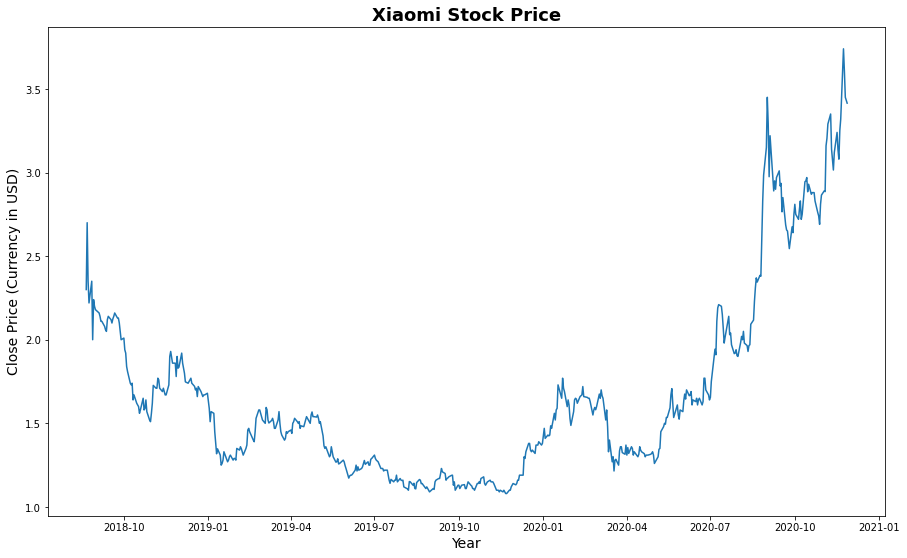

'\nplt.figure()\nplt.plot(stock_xiaomi["Open"])\nplt.plot(stock_xiaomi["High"])\nplt.plot(stock_xiaomi["Low"])\nplt.plot(stock_xiaomi["Close"])\nplt.title(\'Xiaomi stock price history\')\nplt.ylabel(\'Price (USD)\')\nplt.xlabel(\'Days\')\nplt.legend([\'Open\',\'High\',\'Low\',\'Close\'], loc=\'upper left\')\nplt.show()\n'

In [ ]:
#dataframe plots

plt.figure(figsize = (15,9))
plt.plot(stock_xiaomi[['Close']])
plt.title("Xiaomi Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Year',fontsize=14)
plt.ylabel('Close Price (Currency in USD)',fontsize=14)
plt.show()

'''
plt.figure()
plt.plot(stock_xiaomi["Open"])
plt.plot(stock_xiaomi["High"])
plt.plot(stock_xiaomi["Low"])
plt.plot(stock_xiaomi["Close"])
plt.title('Xiaomi stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()
'''

In [ ]:
# new data frame with only significant columns

data = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data['Date'] = stock_xiaomi['Date']
data['Open'] = stock_xiaomi['Open']
data['High'] = stock_xiaomi['High']
data['Low'] = stock_xiaomi['Low']
data['Close'] = stock_xiaomi['Close']

train_set = data.iloc[:, 1:2].values

# scale the dataset before set it to the network
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_set)

X_train, y_train = [], []

# each row in X_train will have 60 prices to use to predict the next-day stock price in y_train
for i in range(60, len(train_set)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0]) 

# convert train df to np arrays to use for LSTM model training
X_train, y_train = np.array(X_train), np.array(y_train)
# reshape into number of samples, number of time steps, number of features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

##Create LSTM model: 
### layers with 50 neurons, two Dense layers: one with 25 neurons and the other with 1 neuron

In [ ]:
forward_days = 5

In [42]:
# LSTM model

lstm_model = Sequential()
# model high dimensionality = 50
lstm_model.add(LSTM(units=50, return_sequences=True,
               input_shape=(X_train.shape[1],1)))
# ignore 20% of 50 neurons randomly during each iteration of training
lstm_model.add(Dropout(rate = 0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(rate = 0.2))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=5)) # output layer
lstm_model.add(Activation('linear'))
print(lstm_model.summary())


#Compile the model
start = time.time()
lstm_model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])
print ('compilation time : ', time.time() - start)



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 130       
_________________________________________________________________
activation_3 (Activation)    (None, 5)                

### Training the model

In [43]:
lstm_model.fit(X_train, y_train,
          epochs=1,
          batch_size=1,
          verbose=1,
          validation_data = (X_train, y_train))

513/513 [==============================] - 20s 34ms/step - loss: 0.0131 - accuracy: 0.0014 - val_loss: 0.0050 - val_accuracy: 0.0000e+00


### Testing the model

In [44]:
# test data set
testdf= yf.download("XIACF",start=datetime.datetime(2020,1,1),end=datetime.datetime(2020,12,5))
testdf['Date'] = testdf.index
# new df with important columns
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdf['Date']
testdata['Open'] = testdf['Open']
testdata['High'] = testdf['High']
testdata['Low'] = testdf['Low']
testdata['Close'] = testdf['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data['Open'], testdata['Open']), axis = 0)

inputs_data = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

X_test = []

for i in range(60, len(inputs_data)):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

[*********************100%***********************]  1 of 1 completed


In [45]:
# reshape x_test into 3-dimensional in the form (n.samples, n.time_steps, n.features)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# get the predicted values from the model
predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
#print(predictions)


## Visualizing the prediction

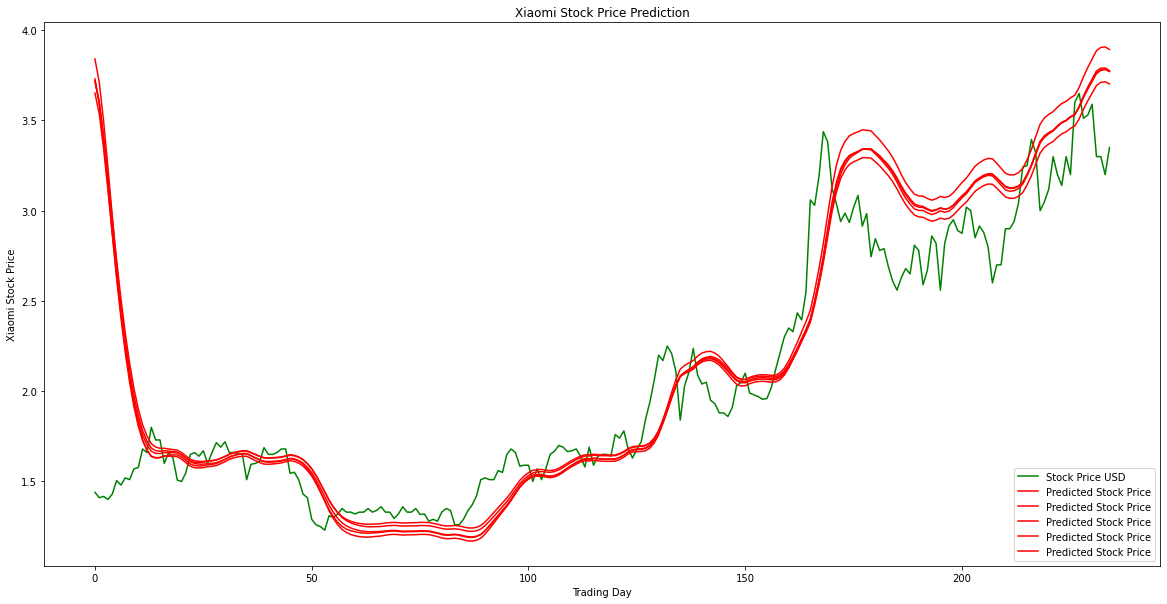

In [49]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'Stock Price USD')
plt.plot(predictions, color = 'red', label = 'Predicted Stock Price')
plt.title('Xiaomi Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Xiaomi Stock Price')
plt.legend()
plt.show()

In [57]:
 
#Get the quoted price
xiaomi_quote = yf.download('XIACF', data_source='yahoo', start='2010-1-1', end='2020-11-30')

new_df = xiaomi_quote.filter(['Close'])

# last 60 day closing price 
last_60_days = new_df[-60:].values

#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Get the predicted scaled price
pred_price = lstm_model.predict(X_test)

#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price) # stock price of the next 5 days


[*********************100%***********************]  1 of 1 completed
[[3.7089293 3.6398323 3.7170553 3.7041411 3.827945 ]]


In [51]:
#Get the quote of december 2020

xiaomi_quote2 = yf.download('XIACF', data_source='yahoo', start='2020-12-1', end='2020-12-17')
print(xiaomi_quote2['Close'])

[*********************100%***********************]  1 of 1 completed
Date
2020-12-01    3.238
2020-12-02    3.210
2020-12-03    3.290
2020-12-04    3.300
2020-12-07    3.230
2020-12-08    3.410
2020-12-09    3.480
2020-12-10    3.580
2020-12-11    3.505
2020-12-14    3.750
2020-12-15    3.800
2020-12-16    3.790
Name: Close, dtype: float64


In [67]:
# get RMSE value to measure of how accurate the model is.
rmse=np.sqrt(np.mean(((pred_price-X_test)**2)))
rmse

2.9924405688207836